In [70]:
import torch
import matplotlib.pyplot as plt
import numpy

from schrodinger import TDSE
from models import FFFC
from conditions import initial_function_1D
from samplers import UniformSampler

In [8]:
pred_dir = 'runs/Apr08_16-49-32_aai-laptop'
model_dir = pred_dir +  '/model.pt'

config = {
    "dim": 1,
    "lr": 1e-3,
    "epochs": int(5000),
    "batch_size": int(1000),
    "frequency": 5,
    "gamma": 0.66,
    "bounds": [1., -1., 1.],
    "print_every": 100
}


fffc = FFFC(config["dim"] + 1, [20, 20, 20])
us = UniformSampler(config['dim'], config['bounds'])
sample = us.sample
tdse = TDSE(fffc, potential=lambda x: 0, initial=initial_function_1D, boundary=lambda x: 0,
            boundary_sampler=us.project_on_boundary)


model_state_dict = torch.load(model_dir)

tdse.model.load_state_dict(model_state_dict)
tdse.model.eval()

FFFC(
  (layers): ModuleDict(
    (input_layer): CustomLayer(
      (linear): Linear(in_features=2, out_features=20, bias=True)
      (activation): Tanh()
    )
    (layer_0): CustomLayer(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (activation): Tanh()
    )
    (layer_1): CustomLayer(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (activation): Tanh()
    )
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [64]:
N = 100
t_grid = torch.linspace(0, config['bounds'][0], N) 
x_grid = torch.linspace(config['bounds'][1], config['bounds'][2], N)

In [65]:
t_grid, x_grid = torch.meshgrid(t_grid, x_grid)

In [82]:
model_input = torch.stack((t_grid, x_grid), axis=-1).view(-1, 2).to("cuda", torch.cfloat)
out = tdse.model(model_input).abs().cpu().detach().numpy().reshape(N, N)
masked_initial = model_input[model_input[:, 0] == 0, :]
initial_data = initial_function_1D(masked_initial).abs().cpu().detach().numpy()
inital_out = tdse.model(masked_initial).abs().cpu().detach().numpy()

out.shape

(100, 100)

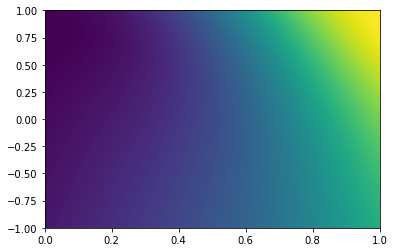

In [83]:
plt.imshow(out, extent=[0, 1, -1, 1], aspect='auto')
plt.show()

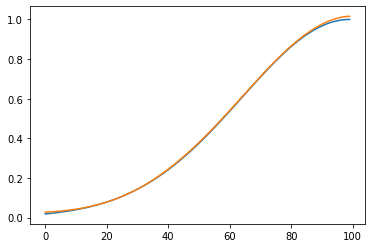

In [84]:
plt.plot(initial_data)
plt.plot(inital_out)
plt.show()